In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import pandas as pd
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import cv2

In [4]:
from safetensors.torch import load_file
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=4,
    problem_type="multi_label_classification"
)

state_dict = load_file("./ViT_doctor.safetensors")
model.load_state_dict(state_dict)
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [5]:
class ViTDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)  # Load image and label
        image = feature_extractor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # Apply feature extractor
        return image, label

In [16]:
!rm -rf /content/Dataset/.ipynb_checkpoints


In [17]:
# === 2. Load Feature Extractor ===
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# === 3. Setup Class Names from Your Dataset ===
# Point to your test dataset folder
test_dataset = datasets.ImageFolder("/content/Dataset")
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# === 4. Load and Preprocess a Single Image ===
image = Image.open("/content/Dataset/Viral Pneumonia/Viral Pneumonia-16.png").convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs["pixel_values"]

# === 5. Predict ===
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    predicted_idx = torch.argmax(outputs.logits, dim=1).item()
    predicted_class = idx_to_class[predicted_idx]

print("Predicted class:", predicted_class)

Predicted class: Viral Pneumonia


# GRAD-CAM.

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.autograd import Function
from torchvision import transforms
from PIL import Image
import requests


model.eval()

# Load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Get the last convolutional layer (for ViT, it's the attention layer)
final_conv_layer = model.vit.encoder.layer[-1].attention.attention

In [19]:
# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get activations
        def save_activation_hook(module, input, output):
            self.activations = output

        # Hook to get gradients
        def save_gradient_hook(module, input, output):
            self.gradients = output[0]

        self.target_layer.register_forward_hook(save_activation_hook)
        self.target_layer.register_backward_hook(save_gradient_hook)

    def forward(self, x):
        return self.model(x)

    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        self.model.zero_grad()
        output = self.forward(input_image)

        # Get the predicted class if target_class is not provided
        if target_class is None:
            target_class = output.logits.argmax(dim=1)

        # Backward pass to get gradients
        self.model.zero_grad()
        output.logits[:, target_class].backward()

        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Ensure activations are not a tuple (some models might return a tuple for activations)
        if isinstance(activations, tuple):
            activations = activations[0]

        # Global average pooling of gradients (across the embedding dimension)
        pooled_gradients = torch.mean(gradients, dim=[0])  # Pooling across the embedding dimension

        # Weight activations by gradients (broadcasting gradients)
        activations = activations * pooled_gradients.unsqueeze(0).unsqueeze(2)  # Shape [batch_size, num_patches, embedding_dim]

        # Average the weighted activations to get the heatmap (across the patches)
        heatmap = activations.mean(dim=1).squeeze()  # Shape: [num_patches]

        # Check heatmap shape before reshaping
        print(f"Heatmap shape before reshaping: {heatmap.shape}")

        # Normalize the heatmap
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize between 0 and 1

        # Remove the [CLS] token (first element) and reshape the heatmap
        heatmap = heatmap[1:]  # Remove the first element (the [CLS] token)
        heatmap = heatmap.mean(dim=-1)
        # Check the shape after removing [CLS] token
        print(f"Heatmap shape after removing [CLS]: {heatmap.shape}")

        # Now, reshape the heatmap to match the grid of patches (14x14)
        grid_size = int(heatmap.shape[0] ** 0.5)
        heatmap = heatmap.reshape(grid_size, grid_size)  # Reshape to a 14x14 grid

        # Check the final heatmap shape after reshaping
        print(f"Heatmap shape after reshaping: {heatmap.shape}")

        return heatmap.detach().numpy()

Heatmap shape before reshaping: torch.Size([197, 768])
Heatmap shape after removing [CLS]: torch.Size([196])
Heatmap shape after reshaping: torch.Size([14, 14])


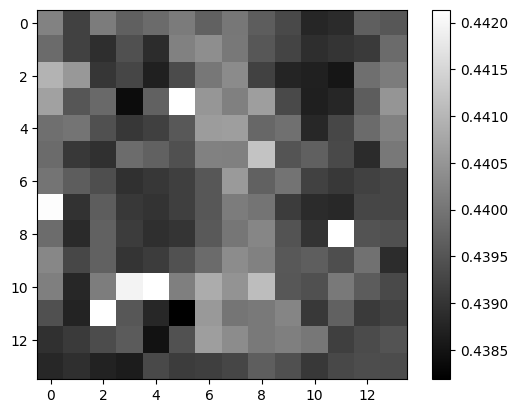

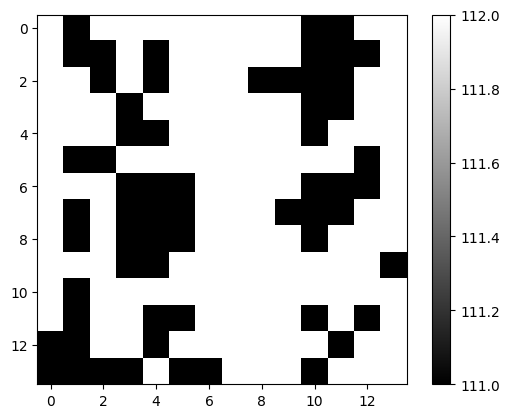

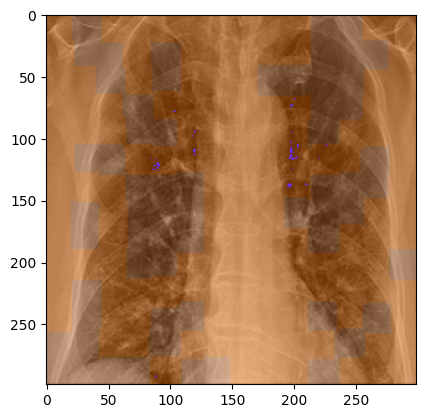

In [59]:
# Preprocess the input image
def preprocess_image(image_path):
    image = Image.open('/content/Dataset/COVID/COVID-26.png').convert("RGB")
    image = feature_extractor(images=image, return_tensors="pt").pixel_values
    return image

# Apply Grad-CAM
def apply_gradcam(image_path):
    image = preprocess_image(image_path)
    grad_cam = GradCAM(model, final_conv_layer)
    heatmap = grad_cam.generate_cam(image)

    # Display the heatmap
    plt.imshow(heatmap, cmap='gray')
    plt.colorbar()
    plt.show()

    # Load and convert the original image to RGB (if not already)
    original_image = Image.open('/content/Dataset/COVID/COVID-26.png').convert("RGB")

    # Convert to numpy array
    original_image = np.array(original_image)

    # Ensure heatmap is a numpy array (already in range [0, 1])
    heatmap = np.uint8(255 * heatmap)  # Normalize heatmap to 0-255 range

    # Display the heatmap
    plt.imshow(heatmap, cmap='gray')
    plt.colorbar()
    plt.show()

    # Expand the heatmap and concatenate to make it 3 channels
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.concatenate([heatmap] * 3, axis=-1)

    # # Normalize the heatmap
    # heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Resize the heatmap to match the original image size
    heatmap_resized = Image.fromarray(heatmap)
    heatmap_resized = heatmap_resized.resize(original_image.shape[1::-1], Image.Resampling.LANCZOS)  # Resize to original image size

    # Convert the resized heatmap back to numpy
    heatmap_resized = np.array(heatmap_resized)

    # Overlay the heatmap on the original image
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = original_image + heatmap_resized * 5


    # Display the result
    plt.imshow(overlay.astype(np.uint8))
    plt.show()

# Use the function on an image
image_path = "/content/Dataset/COVID/COVID-26.png"  # Replace with your image path
apply_gradcam(image_path)



In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Setup the dataset and dataloader
test_dataset = ViTDataset(root="/content/Dataset")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize variables for accuracy
correct = 0
total = 0

# Model evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Get model outputs
        outputs = model(pixel_values=images)
        preds = torch.argmax(outputs.logits, dim=1)

        # Update accuracy
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Display images with predicted and true labels
        for i in range(images.size(0)):
            img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy array for visualization
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for proper display

            true_label = labels[i].item()
            predicted_label = preds[i].item()

            print(f"True: {test_dataset.classes[true_label]} | Pred: {test_dataset.classes[predicted_label]}")
            if true_label != predicted_label:
                plt.imshow(img)
                plt.show()

# Print overall test accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")



True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID


IndexError: list index out of range